# House Prices - ML

**Situation:** This Notebook is based on Kaggle's House Prices dataset. The goal is to correctly predict the price of the houses.  
There are a lot of columns so it will be a big part cleaning the data and identifying the relevant features.  
Evaluation Method is RMSE.  

**Methodology:**


Basic concept:  
1. Step: Import modules / load data
2. Step: EDA 
3. Step: Pre-select features for the model
4. Step: Train models 
5. Step: Discussion of results

### 1. Step: Import modules / load data

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import statsmodels.api as sm
sns.set_theme(style='darkgrid', palette='Set1')
cmap = 'BrBG'
import warnings
warnings.filterwarnings('ignore')
from math import floor

In [86]:
train = pd.read_csv(r'data/train.csv')
test = pd.read_csv(r'data/test.csv')
#submission_sample = pd.read_csv(r'gender_submission.csv')

### 2. Step: EDA & cleaning

In [87]:
print("train shape: ",train.shape)
print("test shape: ",test.shape)

train shape:  (1460, 81)
test shape:  (1459, 80)


So we have 1460 data for training and 1459 for testing.  
Also, we have 80 features + our target variable  
Let's get into the data. First, get an overview of the provided features.  

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

I worked through the data explanation textfile and could identify the following features:  
'SalePrice' is our target variable.  
'ID' is just the index.  

There are 36 numerical features.  
2 of them are actually categorical ('MSSubCLass' and 'MoSold') and need some engineering.  

There are 43 categorical features.  
22 of them are binary or ordinal scaled and can be transformed to numerical features, which we would prefer.

In [89]:
columns= train.columns
target_feature = ['SalePrice']
numerical_features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                     '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
                     'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch','PoolArea','MiscVal','YrSold']
categorical_to_numerical_features = ['Street', 'Alley','LotShape','Utilities','LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','CentralAir','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC',
                    'ExterCond']
numerical_to_categorical_features = ['MoSold', 'MSSubClass']
categorical_features = ['Fence','MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
                       'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','Electrical','GarageType','MiscFeature','SaleType','SaleCondition']

Before we transform these variables to their final type, let's check the quality.  

In [90]:
print('_____Missing Values_____: \n')
columns_with_missing_values = []
for column in columns:
    try:
        if train[column].isnull().sum() + test[column].isnull().sum() > 0:
            columns_with_missing_values.append(column)
            print(column + ' (Train/Test): '+ 
              str(round(train[column].isnull().sum()/len(train[column])*100,2))+'%'+'/'+
              str(round(test[column].isnull().sum()/len(test[column])*100,2))+'%')
    except:
        pass
print('')
print('Total number of features with missing values: ', len(columns_with_missing_values))

_____Missing Values_____: 

MSZoning (Train/Test): 0.0%/0.27%
LotFrontage (Train/Test): 17.74%/15.56%
Alley (Train/Test): 93.77%/92.67%
Utilities (Train/Test): 0.0%/0.14%
Exterior1st (Train/Test): 0.0%/0.07%
Exterior2nd (Train/Test): 0.0%/0.07%
MasVnrType (Train/Test): 0.55%/1.1%
MasVnrArea (Train/Test): 0.55%/1.03%
BsmtQual (Train/Test): 2.53%/3.02%
BsmtCond (Train/Test): 2.53%/3.08%
BsmtExposure (Train/Test): 2.6%/3.02%
BsmtFinType1 (Train/Test): 2.53%/2.88%
BsmtFinSF1 (Train/Test): 0.0%/0.07%
BsmtFinType2 (Train/Test): 2.6%/2.88%
BsmtFinSF2 (Train/Test): 0.0%/0.07%
BsmtUnfSF (Train/Test): 0.0%/0.07%
TotalBsmtSF (Train/Test): 0.0%/0.07%
Electrical (Train/Test): 0.07%/0.0%
BsmtFullBath (Train/Test): 0.0%/0.14%
BsmtHalfBath (Train/Test): 0.0%/0.14%
KitchenQual (Train/Test): 0.0%/0.07%
Functional (Train/Test): 0.0%/0.14%
FireplaceQu (Train/Test): 47.26%/50.03%
GarageType (Train/Test): 5.55%/5.21%
GarageYrBlt (Train/Test): 5.55%/5.35%
GarageFinish (Train/Test): 5.55%/5.35%
GarageCars (Tr

34 features have missing values in the train or test dataset. A lot of them are close to 0%, **PoolQuality** is missing nearly everywhere, also **alley**, **MiscFeature** and **fence** are very high. Let go through all of them.

In [91]:
for i in columns_with_missing_values:
    print(i)
    print(train[i].value_counts())
    print('__________________________')

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
__________________________
LotFrontage
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: LotFrontage, Length: 110, dtype: int64
__________________________
Alley
Grvl    50
Pave    41
Name: Alley, dtype: int64
__________________________
Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
__________________________
Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64
__________________________
Exterior2nd
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng

Based on distribution, datatype and context, we decide the method to fill the missing values.

In [92]:
# For categorical features we set the mode, especially if the mode is the median. 
mode = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','Electrical','Functional','SaleType','KitchenQual']
# All basement-related missing values are handled as "No Basement", same for fireplace and garage
# check it with the following code (example for fireplaces):
# train[train['FireplaceQu'].isna()==True]['Fireplaces'].sum() shows that FirePlaceQu is only missing when there is no Fireplace
na = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
      'BsmtFullBath', 'BsmtHalfBath', 'FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual',
     'GarageCond','Fence','MiscFeature','PoolQC']
# For LotFrontage we need a numerical value. We use median as it is more robust against outlier
median = ['LotFrontage']
# Alley has just a few entries. we won't use it.
delete = ['Alley']


In [93]:
# function to create a dictionary with the filling values for each column (so we can use it later on the test set)
def fill_missing_values(data):
    #initialize dictionary
    fill_na_dict = {column: None for column in columns_with_missing_values}
    # first start with mode:
    for i in mode:
        fill_na_dict[i] = train[i].mode()[0]   
    for j in na:
        if train[j].dtype == 'O':
            fill_na_dict[j] = 'NA'
        else:
            fill_na_dict[j]= 0
    for k in delete:
        fill_na_dict[k] = 'drop_column'
    for l in median:
        fill_na_dict[l] = train[l].median()
    return fill_na_dict

#funtion to correct the datasets
def fill_na(dataset, fill_na_dict):
    for i in fill_na_dict:
        if fill_na_dict[i] == 'drop_column':
            dataset.drop(i,1,inplace = True)
        else:
            dataset[i].fillna(value=fill_na_dict[i], inplace = True)
    return dataset

In [94]:
# now create the dict:
fill_na_dict = fill_missing_values(train)

In [95]:
# now fill the values in the train set
train = fill_na(dataset = train,fill_na_dict = fill_na_dict)

As mentioned we now have to give every column it's correct type.  
Therefore we change categorical values to numerical and vice versa.

In [13]:
def correct_dtypes(dataset):
#Numerical to categorical        
    dataset = dataset.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })
    
    #Categorical to numerical
    dataset = dataset.replace({
                           "Street" : {"Grvl" : 1, "Pave" : 2},    
                           "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                           "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},                       
                           "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                           "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},                      
                           "BsmtQual" : {"NA": 0 , "No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},                      
                           "BsmtCond" : {"NA": 0 , "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},                      
                           "BsmtExposure" : {"NA": 0 , "No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                           "BsmtFinType1" : {"NA": 0 , "No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                             "ALQ" : 5, "GLQ" : 6},
                           "BsmtFinType2" : {"NA": 0 , "No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                             "ALQ" : 5, "GLQ" : 6},
                           "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "CentralAir" : {"N" : 0, "Y" : 1},
                           "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},                      
                           "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                           "Min2" : 6, "Min1" : 7, "Typ" : 8},
                           "FireplaceQu" : {"NA": 0 , "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},                      
                           "GarageFinish" : { "NA" :  0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
                           "GarageQual" : {"NA": 0 , "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "GarageCond" : {"NA": 0 , "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "PavedDrive" : {"NA": 0 , "N" : 0, "P" : 1, "Y" : 2},
                           "PoolQC" : {"NA": 0 , "No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                           "ExterCond" : {"NA": 0 , "Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5}} 
                         )
    return dataset

In [96]:
train = correct_dtypes(train)

Now, let's put the lists together:

In [97]:
numerical_features = numerical_features + categorical_to_numerical_features
numerical_features.remove('Alley')
categorical_features = categorical_features + numerical_to_categorical_features

In [98]:
print('No. of numerical features: ', len(numerical_features))
print('No. of categorical features: ', len(categorical_features))

No. of numerical features:  55
No. of categorical features:  23


We can create some additional features:

In [99]:
def feature_eng(dataset):
    
    dataset['GarageScore'] = (dataset['GarageQual'] * dataset['GarageCond'])**0.5
    
    
    dataset['OverallScore'] = (dataset['OverallQual'] * dataset['OverallCond'])**0.5
    
    dataset['BsmtScore'] = (dataset['BsmtQual'] * dataset['BsmtCond'])**0.5
    
    dataset['ExterScore'] = (dataset['ExterQual'] * dataset['ExterCond'])**0.5
    
    dataset['NoBath'] = dataset['FullBath'] + 0.5*dataset['HalfBath'] + dataset['BsmtFullBath'] + 0.5*dataset['BsmtHalfBath']
    dataset['Age'] = dataset['YrSold'] - dataset['YearBuilt']
    dataset['LastRemod'] = dataset['YrSold'] - dataset['YearRemodAdd']
    dataset['AgeGar'] = dataset['YrSold'] - dataset['GarageYrBlt']
    
    list_of_new_features = ['GarageScore','OverallScore','BsmtScore','ExterScore','NoBath','Age','LastRemod','AgeGar']
    
    return dataset , list_of_new_features

In [100]:
train, new_features = feature_eng(train)
numerical_features = numerical_features + new_features

Let's have a  look at the scatter plots for the numerical data to understand the relation

In [101]:
train[target_feature[0]]

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice_log', ylabel='Density'>

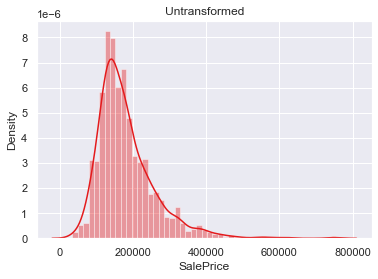

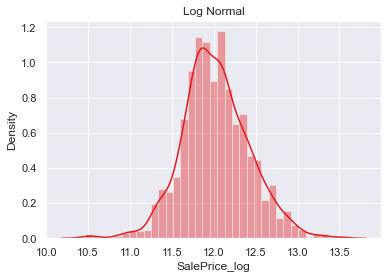

In [102]:
train['SalePrice_log'] = np.log1p(train['SalePrice'].values) 
y = train['SalePrice']
y2 = train['SalePrice_log']
plt.figure(1); plt.title('Untransformed')
sns.distplot(y, kde=True)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y2, kde=True)

In [103]:
num_core = numerical_features+target_feature
num_core.append('SalePrice_log')
num_core.remove('SalePrice')


<AxesSubplot:>

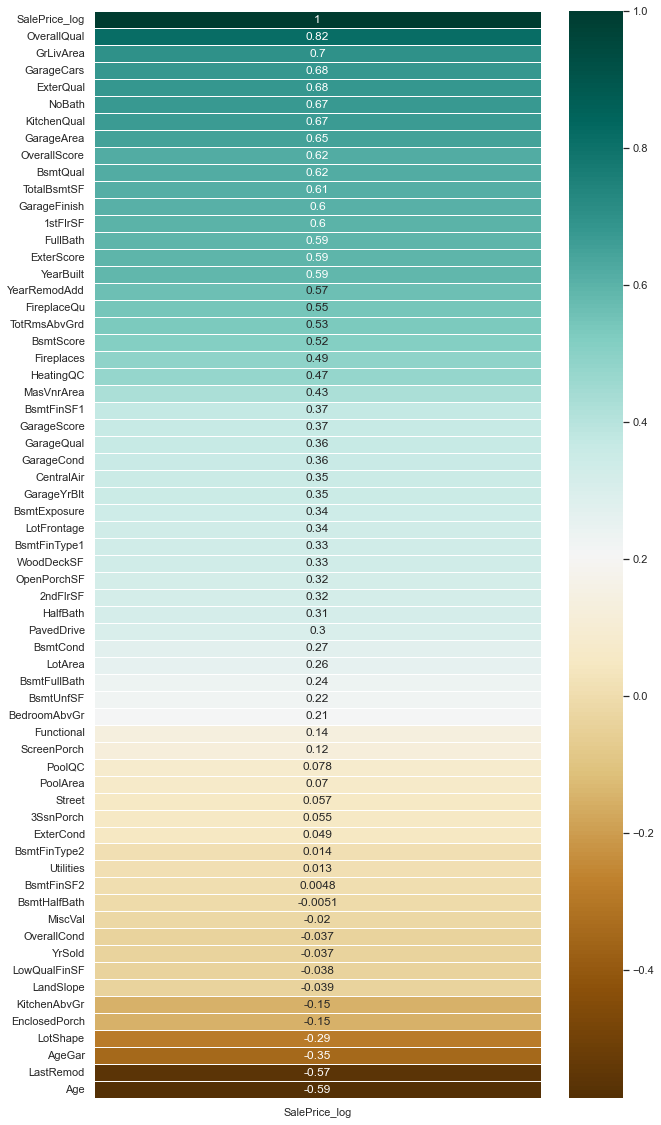

In [104]:
fig, ax = plt.subplots(figsize=(10,20))

sns.heatmap(train[num_core].corr()[['SalePrice_log']].sort_values(by='SalePrice_log',ascending=False),cmap = cmap,annot = True,linewidths=.5)

Comment on correlations...

In [105]:
# we keep this sorting for going deeper in the graphical analysis
num_core = train[num_core].corr()[['SalePrice_log']].sort_values(by='SalePrice_log',ascending=False).index.to_list()
corr_dict = train[num_core].corr()[['SalePrice_log']].sort_values(by='SalePrice_log',ascending=False)['SalePrice_log'].to_dict()
target_variable= 'SalePrice_log'

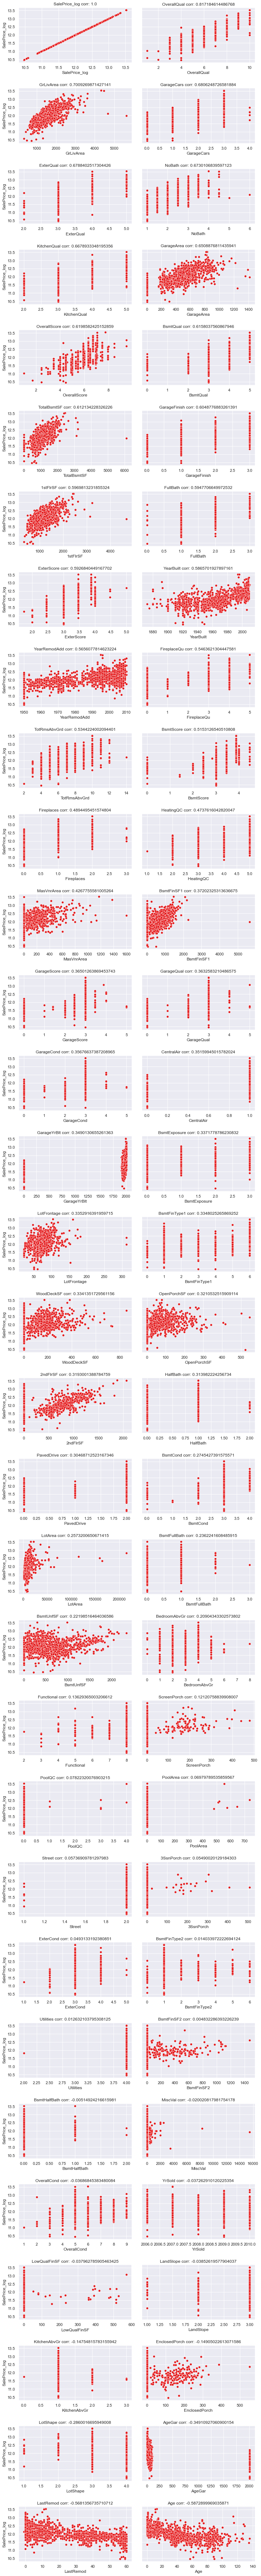

In [106]:
fig, axes = plt.subplots(round(len(numerical_features)/2),2,figsize=(10,100),sharey =True)
fig.tight_layout(h_pad=4)
a = 0
b = 0
for i in num_core:
    sns.scatterplot(data= train, x=train[i], y=train[target_variable], ax = axes[a,b])
    title = i + " corr: " + str(corr_dict[i])
    axes[a,b].set_title(title)
    b+=1
    if b == 2:
        a+=1
        b=0

In [107]:
#Cleaning the outlier
# IQR
outlier = ['GrLivArea', 'GarageArea', 'TotalBsmtSF']
for feature in outlier:
    Q1 = np.percentile(train[feature], 25,
                       interpolation = 'midpoint')

    Q3 = np.percentile(train[feature], 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Upper bound
    upper = np.where(train[feature] >= (Q3+1.5*IQR))
    # Lower bound
    #lower = np.where(train[feature] <= (Q1-1.5*IQR))
    ''' Removing the Outliers '''
    train.drop(upper[0], inplace = True)
    #train.drop(lower[0], inplace = True)
    train.reset_index(drop=True,inplace = True)
train.drop(np.where(train['MasVnrArea'] >= 1200)[0], inplace = True)
train.reset_index(drop=True,inplace = True)

In [108]:
train.shape

(1390, 89)

### 3. Step: Pre-select features for the model

We don't want to blindly fill the model with all features. The amount of features will cost a lot of computing capacity and we already did some analysis to make a decision wich features we use for the start. We will first choose our set of features by their correlation to the target variable and afterwards deselct all candidates for multicollinearity. 

<AxesSubplot:>

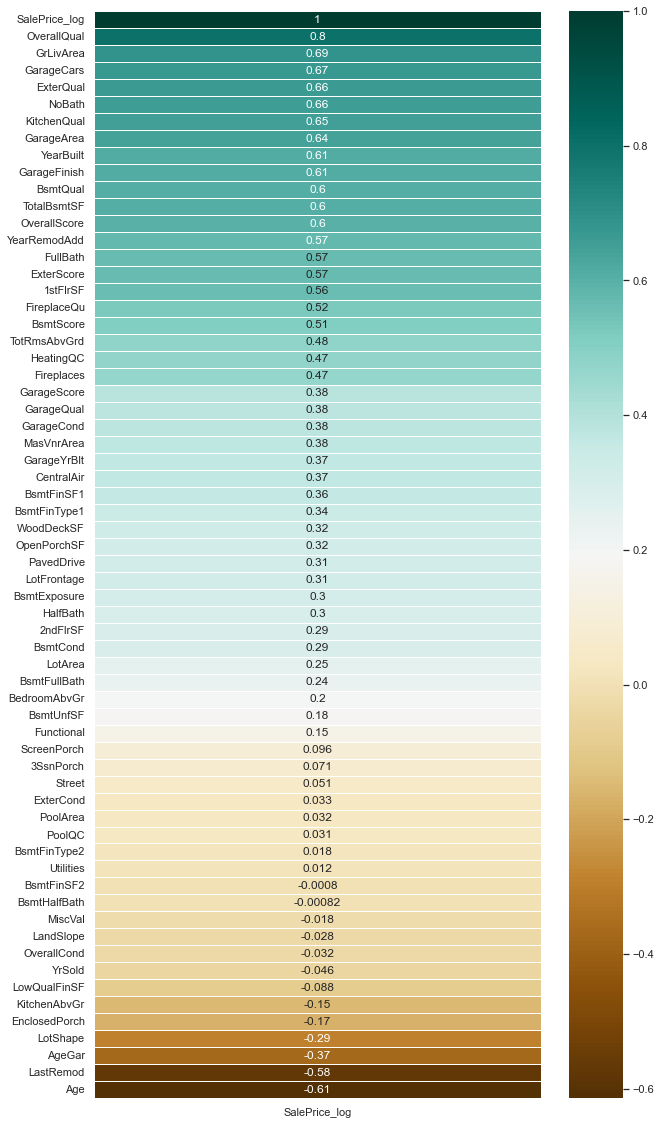

In [109]:
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(train[num_core].corr()[['SalePrice_log']].sort_values(by='SalePrice_log',ascending=False),cmap = cmap,annot = True,linewidths=.5)

For the start we will choose the absolute value of 0.3 as the lower limit of the correlation coefficient to select the features.   
Some sources name 0.3 as the border from 'weak' to 'moderate' correlation. Of course this can not be seen that strict. But as we need a starting point it makes a good way to take this value.  

In [110]:
limit = 0.3
limit_filter = train[num_core].corr()[['SalePrice_log']].abs()>limit
selected_num_features = limit_filter[limit_filter['SalePrice_log']==True].index.to_list()

Now check for multicollinearity

<AxesSubplot:>

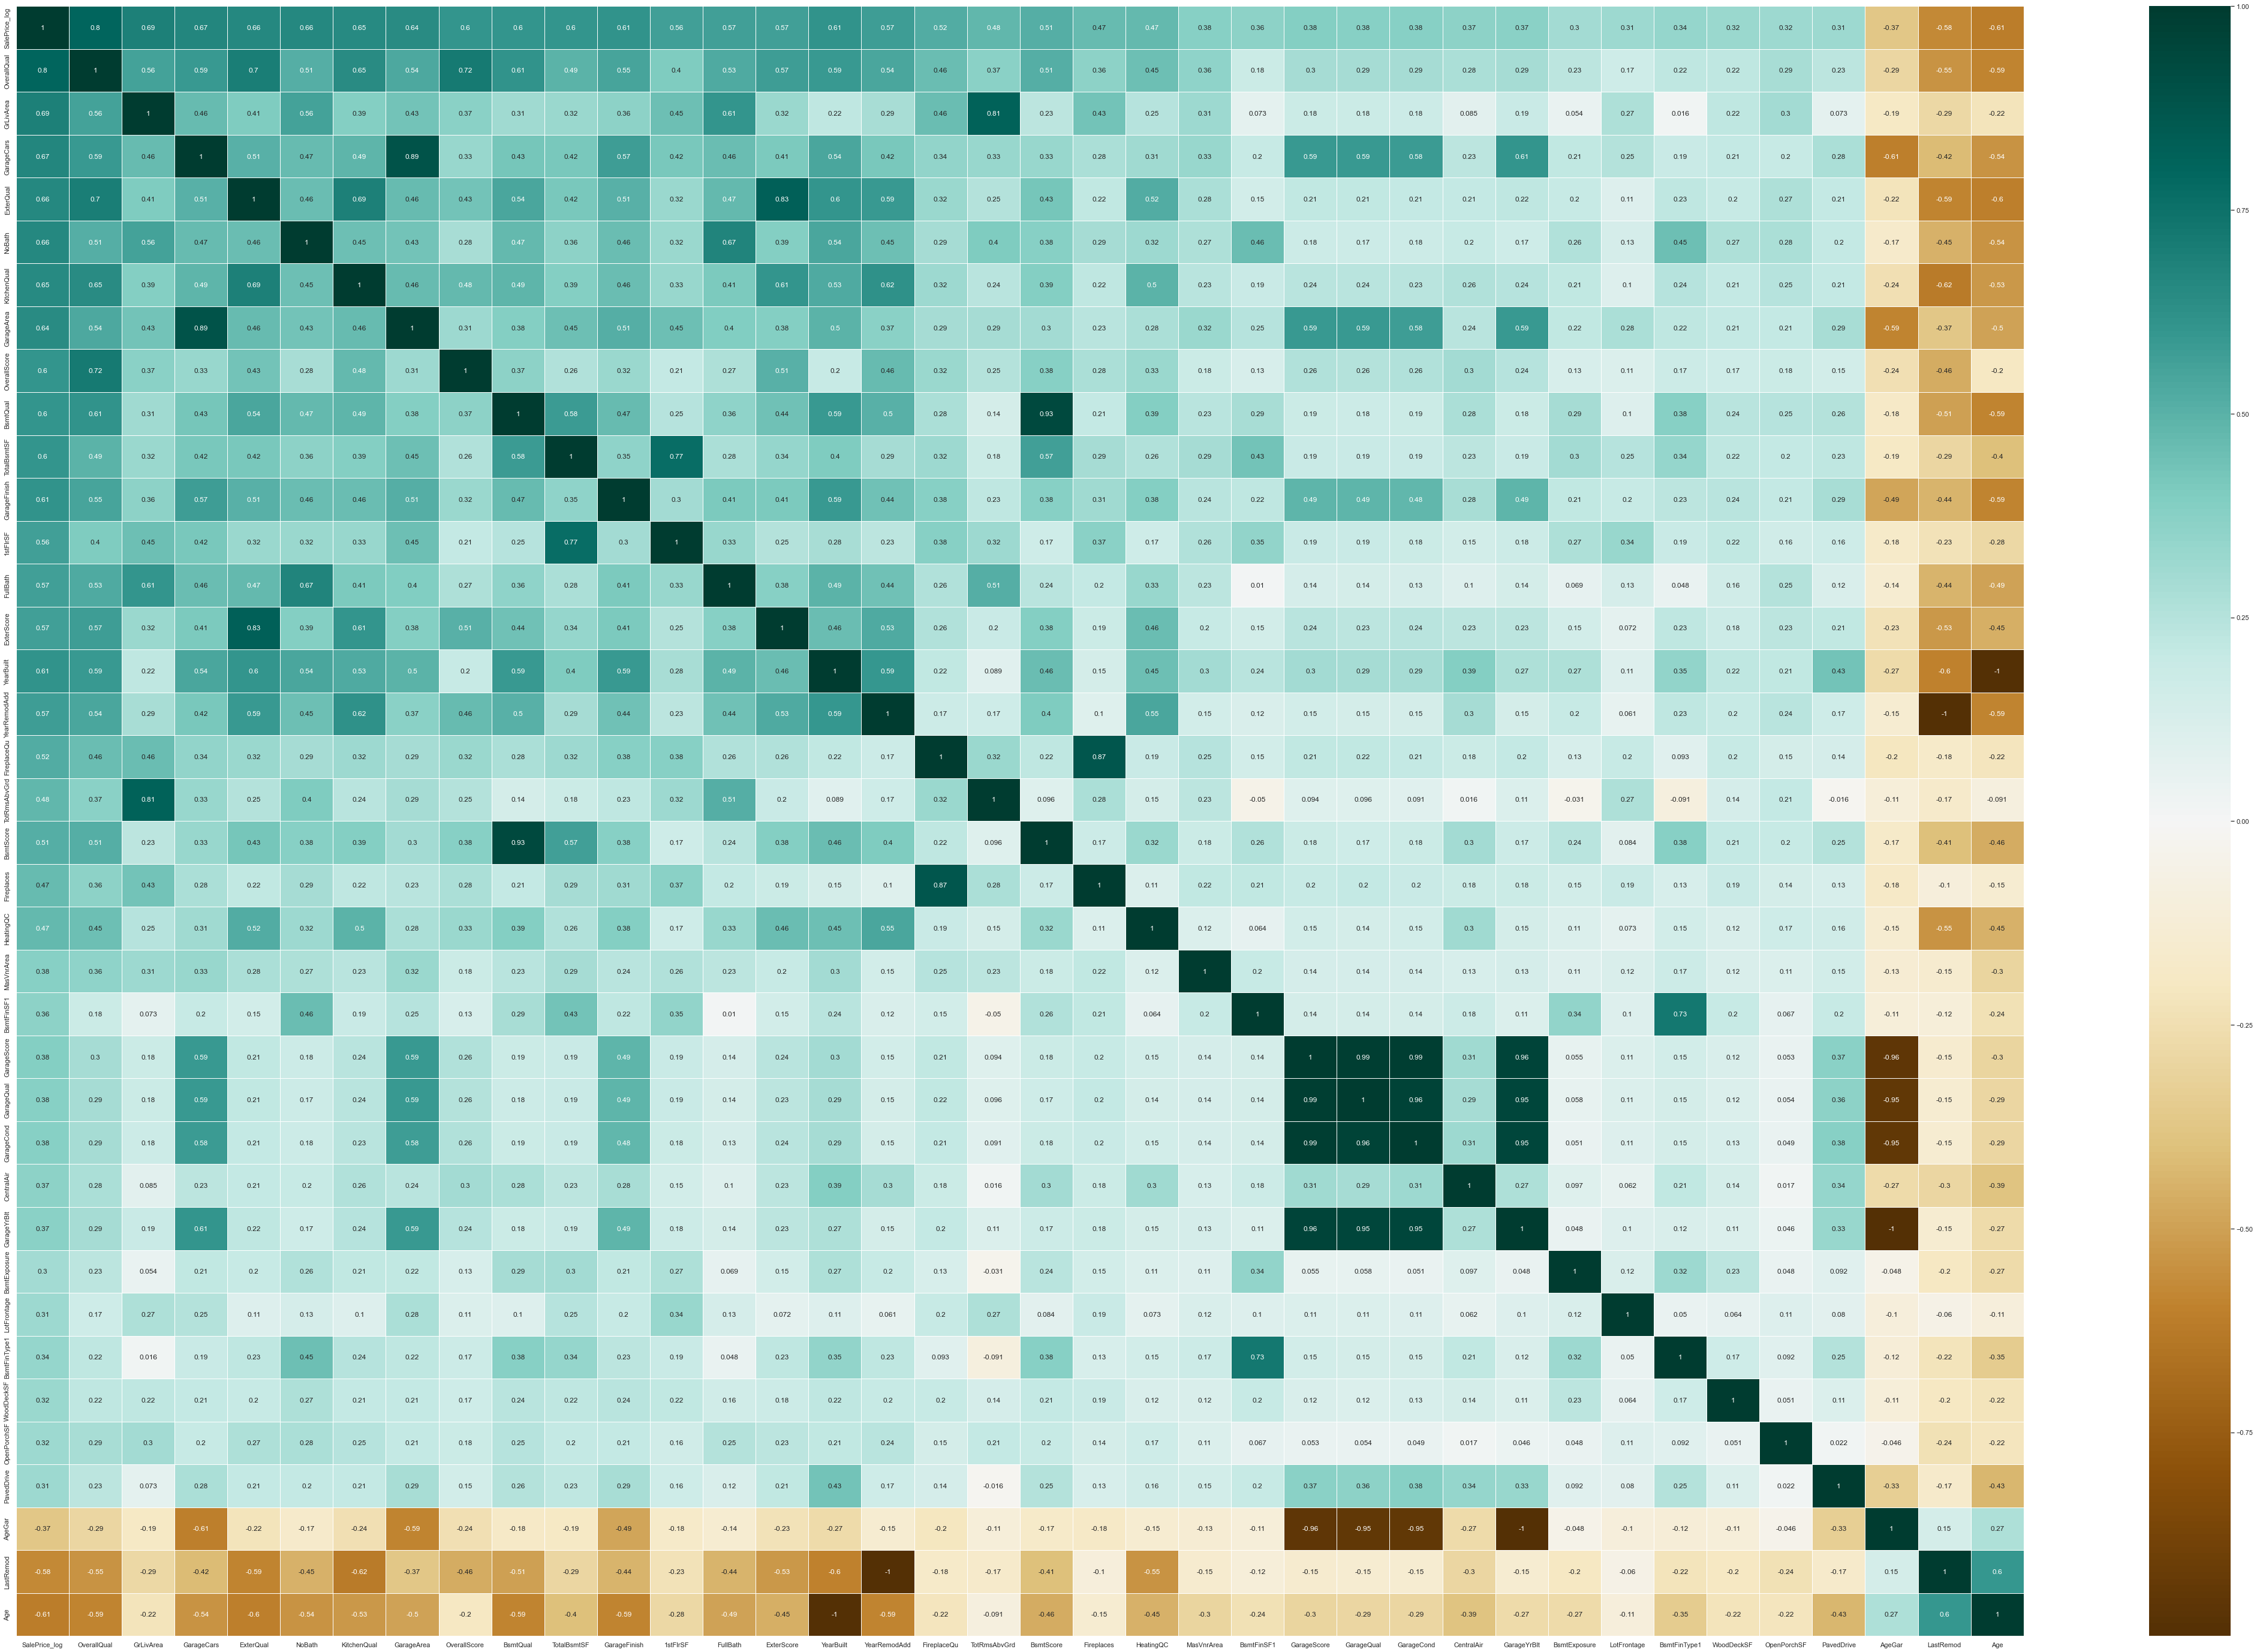

In [111]:
fig, ax = plt.subplots(figsize=(75,50))
sns.heatmap(train[selected_num_features].corr(),cmap = cmap,annot = True,linewidths=.5)

In [112]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def VIF(X):    
    variables = X
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
    vif["Features"] = X.columns
    print(vif)

In [113]:
selected_num_features_r = selected_num_features.copy()
selected_num_features_r.remove('SalePrice_log')
VIF(train[selected_num_features_r])

             VIF      Features
0   1.466026e+02   OverallQual
1   6.447088e+01     GrLivArea
2   4.098901e+01    GarageCars
3   2.238815e+02     ExterQual
4   3.608591e+01        NoBath
5   7.656974e+01   KitchenQual
6   3.450516e+01    GarageArea
7   2.033313e+02  OverallScore
8   2.332962e+02      BsmtQual
9   4.680577e+01   TotalBsmtSF
10  1.041397e+01  GarageFinish
11  5.743273e+01      1stFlrSF
12  2.861576e+01      FullBath
13  4.287126e+02    ExterScore
14           inf     YearBuilt
15           inf  YearRemodAdd
16  9.635385e+00   FireplaceQu
17  6.366519e+01  TotRmsAbvGrd
18  3.169456e+02     BsmtScore
19  8.748224e+00    Fireplaces
20  3.233231e+01     HeatingQC
21  1.730227e+00    MasVnrArea
22  6.293223e+00    BsmtFinSF1
23  1.060599e+05   GarageScore
24  2.751237e+04    GarageQual
25  2.775762e+04    GarageCond
26  2.285625e+01    CentralAir
27           inf   GarageYrBlt
28  1.816444e+00  BsmtExposure
29  1.550458e+01   LotFrontage
30  9.931243e+00  BsmtFinType1
31  1.82

There are a lot of highly intercorrelated variables. We will deselect some redundant now that have an correlation coefficent >0.8.  
We should keep that multicollinearity problem in mind and use PCA and/or models that can work with that.

In [114]:
remove = ['GarageYrBlt','GarageFinish','GarageArea', 'GarageQual', 'GarageCond','AgeGar','YearBuilt','YearRemodAdd','BsmtFinSF1','TotRmsAbvGrd', 'ExterScore','BsmtScore']
for r in remove:
    selected_num_features_r.remove(r)

In [115]:
len(selected_num_features_r)

25

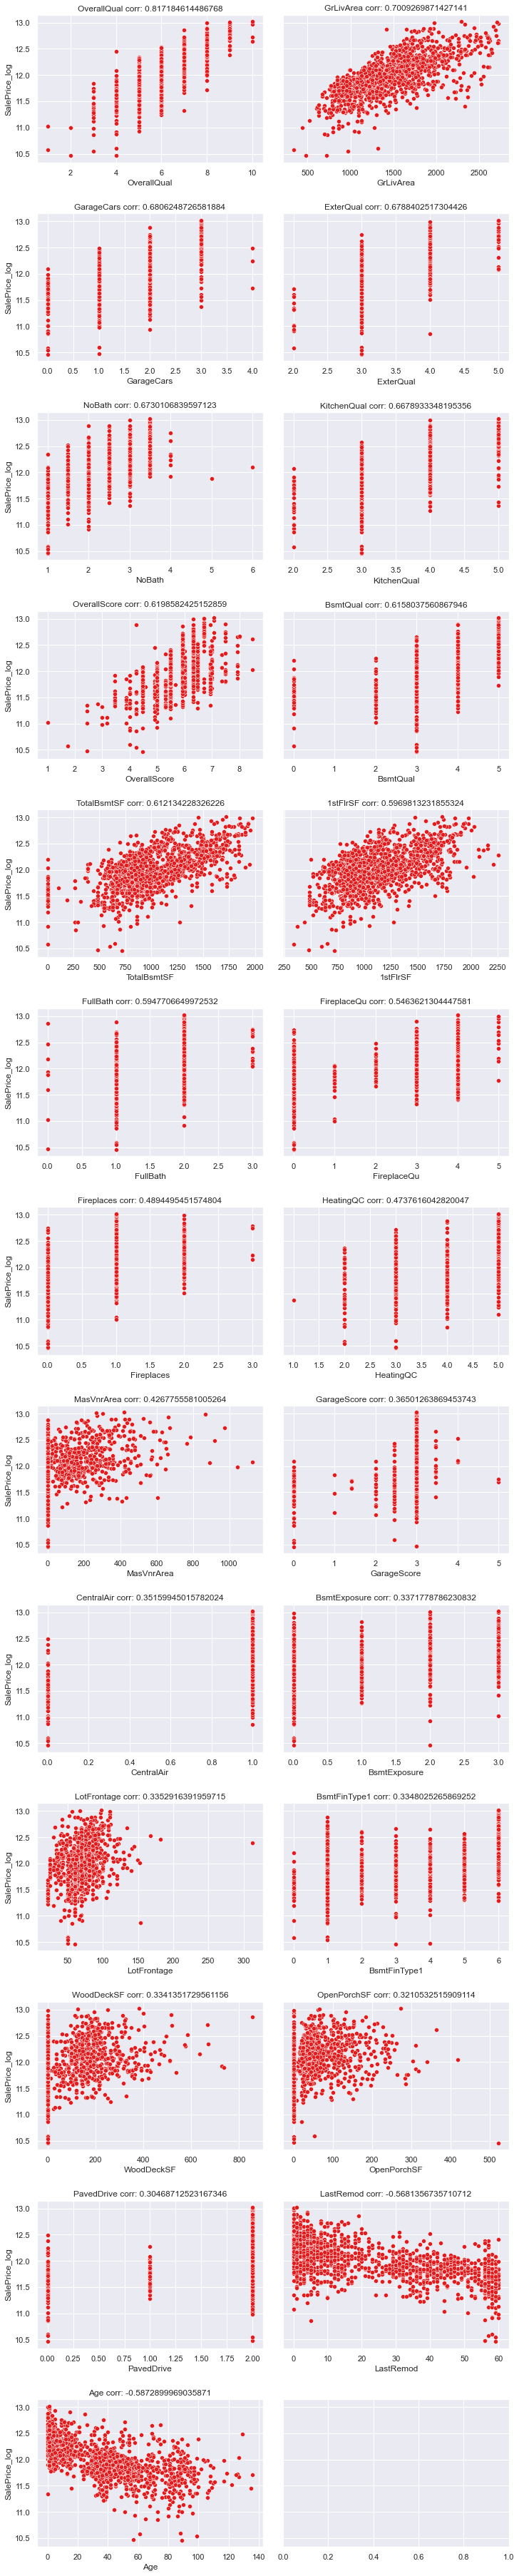

In [116]:
fig, axes = plt.subplots(round(len(selected_num_features_r)/2+0.5),2,figsize=(10,50),sharey =True)
fig.tight_layout(h_pad=4)
a = 0
b = 0
for i in selected_num_features_r:
    sns.scatterplot(data= train, x=train[i], y=train[target_variable], ax = axes[a,b])
    title = i + " corr: " + str(corr_dict[i])
    axes[a,b].set_title(title)
    b+=1
    if b == 2:
        a+=1
        b=0

So this is the set of numerical features we will use in the models.  
Let's check the categorical features:

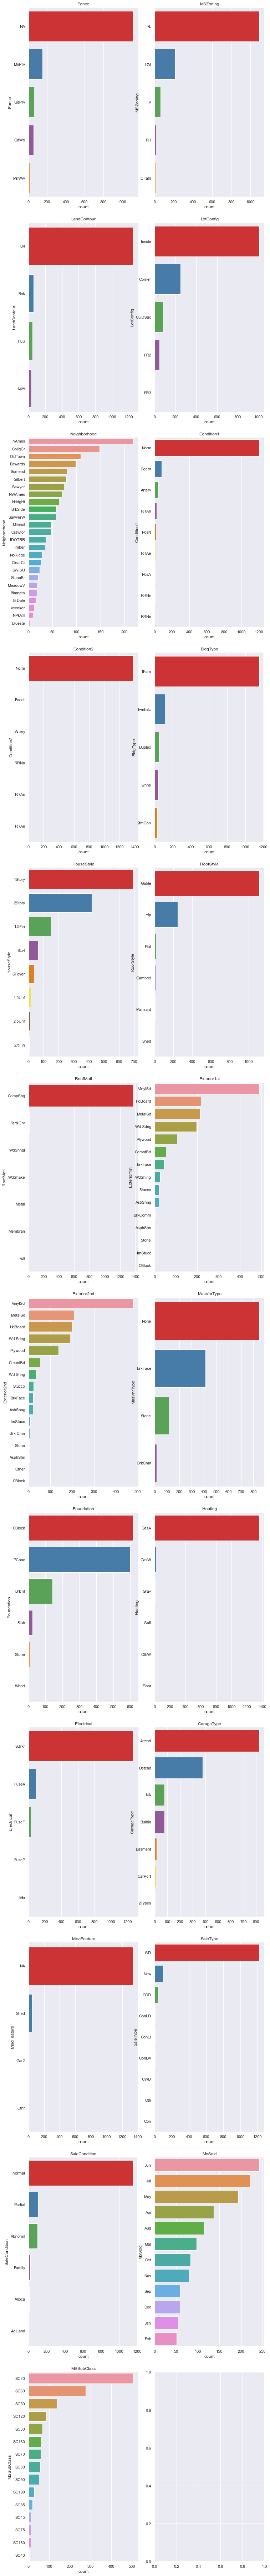

In [117]:
fig, axes = plt.subplots(round(len(categorical_features)/2),2,figsize=(10,100))
fig.tight_layout(h_pad=4)
a = 0
b = 0
for i in categorical_features:
    sns.countplot(data= train, y=train[i], ax = axes[a,b],order = train[i].value_counts().index)
    title = i
    axes[a,b].set_title(title)
    b+=1
    if b == 2:
        a+=1
        b=0

In some features, nearly all values are in one category and the sample sizes for the other categories are too small to generate valid predictions from it.  
We will remove:  

    - Condition2  
    - RoofMatl  
    - Heating  
    - MiscFeature  

A lot of the other features are also concentrated in one category. In the model, we will use pca, transformation and scaling to improve them.  

In [118]:
categorical_features.remove('Condition2')
categorical_features.remove('RoofMatl')
categorical_features.remove('Heating')
categorical_features.remove('MiscFeature')
selected_categorical_features = categorical_features

In [119]:
all_features = selected_categorical_features + selected_num_features_r

### 4.Step: Train models

Preprocessing

In [120]:
#models preprocessing
#encode
target = train[['SalePrice_log']]
train = train[all_features]
#train[selected_categorical_features] = pd.get_dummies(train[selected_categorical_features])
train = pd.get_dummies(train)


In [121]:
#train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.20, random_state = 28112015)

In [122]:
#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train[selected_num_features_r] = scaler.fit_transform(X_train[selected_num_features_r])
X_test[selected_num_features_r] = scaler.transform(X_test[selected_num_features_r])

In [123]:
# We will use pca to reduce multicollinearity 
# inspired by https://towardsdatascience.com/one-hot-encoding-standardization-pca-data-preparation-steps-for-segmentation-in-python-24d07671cf0b
from sklearn.decomposition import PCA

for comp in range(3, X_train.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(X_train)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.99:
        break
        
Final_PCA = PCA(n_components= final_comp,random_state=42)
X_train_pca = Final_PCA.fit_transform(X_train)
X_test_pca =Final_PCA.transform(X_test)

num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()))

Using 120 components, we can explain 0.9901329837213014% of the variability in the original data.


#### Train the models:

In [42]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

In [43]:
#dictionary to store results
models = [
    { "model": "1. Linear Regression" },
    { "model": "2. Ridge Regression" },
    { "model": "3. Lasso Regression" },
    { "model": "4. Elastic Net" },
    { "model": "5. KNN" },
    { "model": "6. SVM" },
    { "model": "7. Decision Tree" },
    { "model": "8. Random Forest" },
    { "model": "9. GBM" },
    { "model": "10. LGBM" },
    { "model": "11. XGBoost" },
    ]
scores_dict = {model["model"]: [] for model in models}

In [172]:
#helper for plots
def plot_res(y_train_pred,y_train,y_test_pred,y_test):
    # Plot residuals
    plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data",alpha=0.4)
    plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data",alpha=0.4)
    plt.title("Linear regression")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
    plt.show()

    # Plot predictions
    plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data", alpha=0.4)
    plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data",alpha=0.4)
    plt.title("Linear regression")
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()

def plot_feat1(algo,index = X_train):
    # Plot important coefficients
    coefs = pd.Series(algo.coef_[0], index = X_train.columns)
    print("Model picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
          str(sum(coefs == 0)) + " features")
    imp_coefs = pd.concat([coefs.sort_values().head(10),
                         coefs.sort_values().tail(10)])
    imp_coefs.plot(kind = "barh")
    title = "Coefficients in the Model"
    plt.title(title)
    plt.show()
    
def plot_feat2(algo,index = X_train):
    # Plot important coefficients
    coefs = pd.Series(algo.coef_, index = X_train.columns)
    print("Model picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
          str(sum(coefs == 0)) + " features")
    imp_coefs = pd.concat([coefs.sort_values().head(10),
                         coefs.sort_values().tail(10)])
    imp_coefs.plot(kind = "barh")
    title = "Coefficients in the Model"
    plt.title(title)
    plt.show()

def plot_feat3(algo,index = X_train):
    # Feature importances
    Feature = pd.DataFrame({'feature':index.columns, 'importance':list(algo.feature_importances_)}).sort_values('importance', ascending=False)
    plt.figure(figsize=(16,4))
    sns.barplot(data=Feature.head(10), x='feature', y='importance')
    plt.xticks(rotation=90)
    plt.show()
 
    

**1. Linear Regression**

Training error (RMSE): 0.10491399864680807
Test error (RMSE): 0.12018711678755616


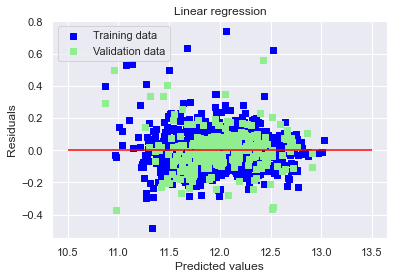

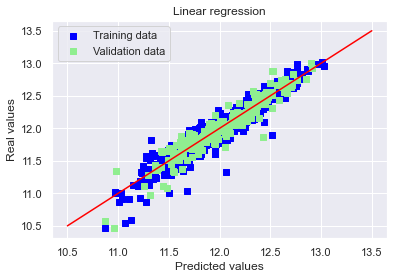

In [126]:
# Linear Regression with PCA
lr = LinearRegression()
lr.fit(X_train_pca, y_train)

y_train_pred = lr.predict(X_train_pca)
y_test_pred = lr.predict(X_test_pca)

train_error = mean_squared_error(y_train, y_train_pred,squared=False)
test_error = mean_squared_error(y_test, y_test_pred,squared=False)

print('Training error (RMSE): ' + str(train_error))
print('Test error (RMSE): ' + str(test_error))

plot_res(y_train_pred,y_train,y_test_pred,y_test)

scores_dict['1. Linear Regression'].append(test_error)

**1. Ridge Regression**

Best alpha : 3.0
Try again for more precision with alphas centered around 3.0
Best alpha : 3.1500000000000004
Ridge RMSE on Training set : 0.10109077674127936
Ridge RMSE on Test set : 0.11621535509292596


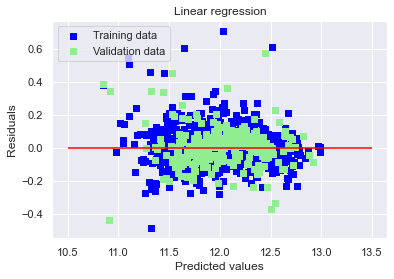

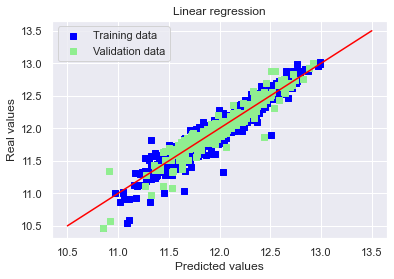

Ridge picked 188 features and eliminated the other 4 features


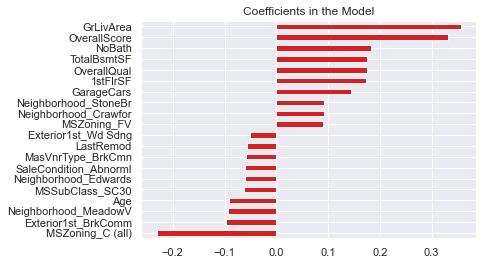

In [142]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)

alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)
train_error = mean_squared_error(y_train, y_train_rdg,squared=False)
test_error = mean_squared_error(y_test, y_test_rdg,squared=False)

print("Ridge RMSE on Training set :", train_error)
print("Ridge RMSE on Test set :", test_error)

plot_res(y_train_rdg,y_train,y_test_rdg,y_test)

# Plot important coefficients
plot_feat1(ridge)

scores_dict['2. Ridge Regression'].append(test_error)

**3. Lasso Regression**

Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.00057
Lasso RMSE on Training set : 0.10476231323282202
Lasso RMSE on Test set : 0.1123846417210776


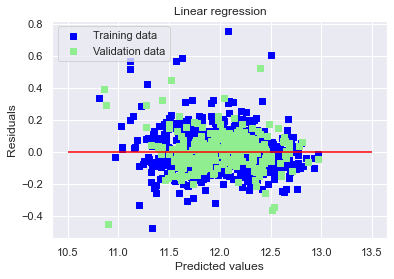

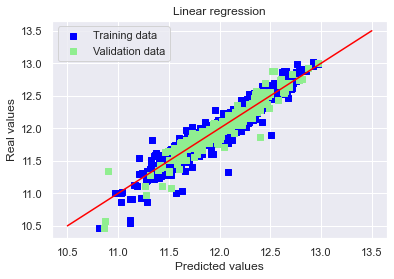

Model picked 78 features and eliminated the other 114 features


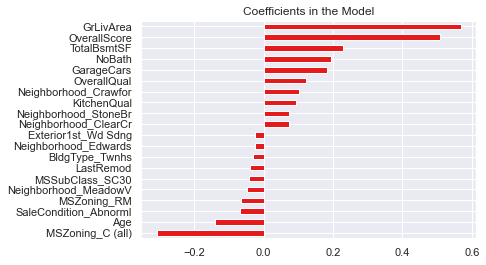

In [150]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)
train_error = mean_squared_error(y_train, y_train_las,squared=False)
test_error = mean_squared_error(y_test, y_test_las,squared=False)

print("Lasso RMSE on Training set :", train_error)
print("Lasso RMSE on Test set :", test_error)

plot_res(y_train_las.reshape(1112,1),y_train,y_test_las.reshape(278,1),y_test)

plot_feat2(algo=lasso)


scores_dict['3. Lasso Regression'].append(test_error)

In [ ]:
**4. Elastic Net**

Best l1_ratio : 0.95
Best alpha : 0.0006
Try again for more precision with l1_ratio centered around 0.95
Best l1_ratio : 0.95
Best alpha : 0.0006
Now try again for more precision on alpha, with l1_ratio fixed at 0.95 and alpha centered around 0.0006
Best l1_ratio : 0.95
Best alpha : 0.00057
ElasticNet RMSE on Training set : 0.10449681078633474
ElasticNet RMSE on Test set : 0.11238729662365816


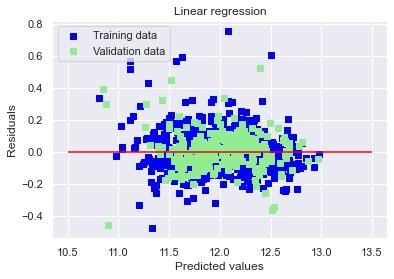

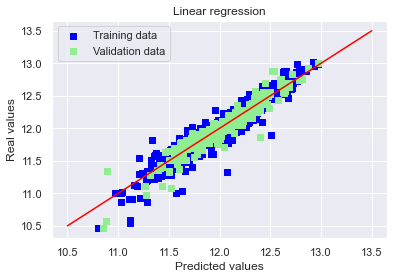

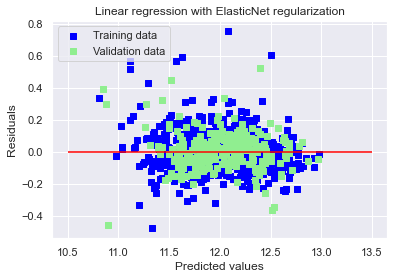

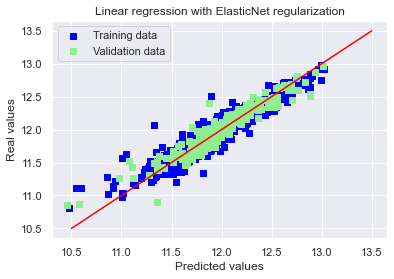

Model picked 79 features and eliminated the other 113 features


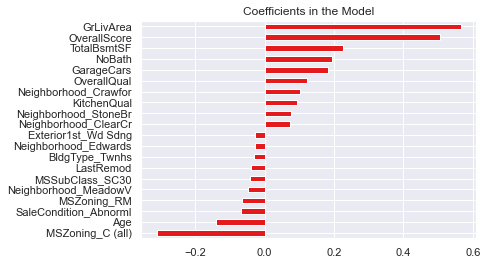

ElasticNet picked 79 features and eliminated the other 113 features


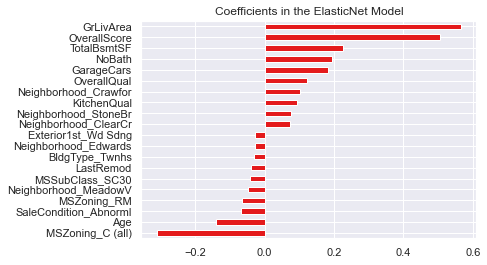

In [151]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

train_error = mean_squared_error(y_train, y_train_ela,squared=False)
test_error = mean_squared_error(y_test, y_test_ela,squared=False)

print("ElasticNet RMSE on Training set :",train_error)
print("ElasticNet RMSE on Test set :", test_error)

scores_dict['4. Elastic Net'].append(test_error)

plot_res(y_train_ela.reshape(1112,1),y_train,y_test_ela.reshape(278,1),y_test)

plot_feat2(algo=elasticNet)


**5. KNN**

In [49]:
from sklearn.neighbors import KNeighborsRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split, cross_val_score

https://www.kaggle.com/rendyk/regression-rmse-house-prices

In [50]:
# Hyperparameter-tuning: Bayesian Optimization, bayes_opt
def knn_re_bo(n_neighbors, weights, algorithm):
    params_knn = {}
    
    weightsL = ['uniform', 'distance']
    algorithmL = ['auto', 'ball_tree', 'kd_tree', 'brute', 'brute']
    
    params_knn['n_neighbors'] = round(n_neighbors)
    params_knn['weights'] = weightsL[round(weights)]
    params_knn['algorithm'] = algorithmL[round(algorithm)]
    params_knn['n_jobs'] = -1
    
    scores = cross_val_score(KNeighborsRegressor(**params_knn),
                             X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()
    score = ((scores*-1)**0.5)*-1
    return score

# Set hyperparameters spaces
params_knn ={
    'n_neighbors':(3, 20),
    'weights':(0,1),
    'algorithm':(0, 4)
}

# Run Bayesian Optimization
knn_bo = BayesianOptimization(knn_re_bo, params_knn, random_state=123)
knn_bo.maximize(init_points=4, n_iter=25)



|   iter    |  target   | algorithm | n_neig... |  weights  |
-------------------------------------------------------------
|  1        | -0.2004   |  2.786    |  7.864    |  0.2269   |
|  2        | -0.2013   |  2.205    |  15.23    |  0.4231   |
|  3        | -0.2013   |  3.923    |  14.64    |  0.4809   |
|  4        | -0.1977   |  1.568    |  8.834    |  0.729    |
|  5        | -0.1977   |  1.075    |  9.419    |  0.9778   |
|  6        | -0.1984   |  0.0      |  7.858    |  1.0      |
|  7        | -0.2002   |  0.0      |  10.98    |  0.0      |
|  8        | -0.1974   |  2.66     |  10.32    |  1.0      |
|  9        | -0.2061   |  0.0      |  3.0      |  1.0      |
|  10       | -0.2023   |  0.0      |  20.0     |  1.0      |
|  11       | -0.2052   |  4.0      |  20.0     |  0.0      |
|  12       | -0.2002   |  3.91     |  10.95    |  0.03008  |
|  13       | -0.1977   |  2.01     |  12.02    |  1.0      |
|  14       | -0.1979   |  0.0      |  13.68    |  1.0      |
|  15   

In [51]:
# Best hyperparameters
params_knn = knn_bo.max['params']

weightsL = ['uniform', 'distance']
algorithmL = ['auto', 'ball_tree', 'kd_tree', 'brute', 'brute']

params_knn['n_neighbors'] = round(params_knn['n_neighbors'])
params_knn['weights'] = weightsL[round(params_knn['weights'])]
params_knn['algorithm'] = algorithmL[floor(params_knn['algorithm'])]
params_knn['n_jobs'] = -1
params_knn

{'algorithm': 'kd_tree',
 'n_neighbors': 13,
 'weights': 'distance',
 'n_jobs': -1}

KNN RMSE on Training set : 0.0
KNN RMSE on Test set : 0.18765671879743057


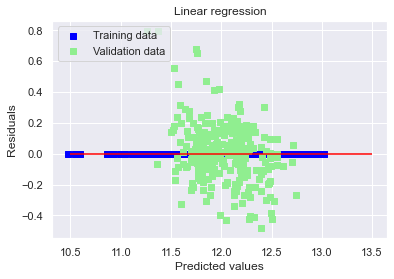

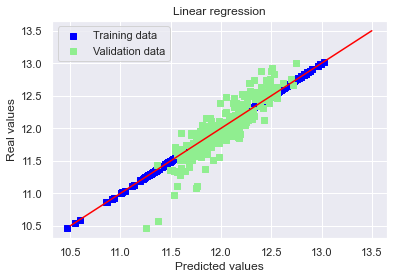

In [153]:
# Fit the training data
knn_hyp =  KNeighborsRegressor(**params_knn)
knn_hyp.fit(X_train, y_train)

# Predict the validation data
y_train_knn = knn_hyp.predict(X_train)
y_test_knn = knn_hyp.predict(X_test)


# Compute the RMSE
train_error = mean_squared_error(y_train, y_train_knn,squared=False)
test_error = mean_squared_error(y_test, y_test_knn,squared=False)

print("KNN RMSE on Training set :", train_error)
print("KNN RMSE on Test set :", test_error)

scores_dict['5. KNN'].append(test_error)

plot_res(y_train_knn.reshape(1112,1),y_train,y_test_knn.reshape(278,1),y_test)

**6. SVM**

In [53]:
from sklearn.svm import SVR

In [54]:
# Hyperparameter-tuning: Bayesian Optimization, bayes_opt
def svm_re_bo(C, epsilon):
    params_svm = {}
    params_svm['C'] = C
    params_svm['epsilon'] = epsilon
    
    scores = cross_val_score(SVR(**params_svm),
                             X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()
    score = ((scores*-1)**0.5)*-1
    return score

# Set hyperparameters spaces
params_svm ={
    #'kernel':(0, 5),
    'C':(0.01, 10),
    'epsilon':(0.01, 1)
}

# Run Bayesian Optimization
svm_bo = BayesianOptimization(svm_re_bo, params_svm)
svm_bo.maximize(init_points=4, n_iter=25)

|   iter    |  target   |     C     |  epsilon  |
-------------------------------------------------
|  1        | -0.2161   |  3.643    |  0.4906   |
|  2        | -0.132    |  2.577    |  0.09512  |
|  3        | -0.18     |  1.945    |  0.3263   |
|  4        | -0.1969   |  8.271    |  0.4108   |
|  5        | -0.1311   |  2.47     |  0.0895   |
|  6        | -0.3784   |  6.054    |  1.0      |
|  7        | -0.1308   |  10.0     |  0.01     |
|  8        | -0.3784   |  10.0     |  1.0      |
|  9        | -0.252    |  0.01     |  0.01     |
|  10       | -0.1308   |  9.227    |  0.01     |
|  11       | -0.3784   |  2.63     |  1.0      |
|  12       | -0.1259   |  1.217    |  0.01692  |
|  13       | -0.3236   |  0.9278   |  0.8304   |
|  14       | -0.1297   |  4.571    |  0.01     |
|  15       | -0.2668   |  4.601    |  0.6656   |
|  16       | -0.1301   |  5.131    |  0.01     |
|  17       | -0.1307   |  7.368    |  0.01     |
|  18       | -0.2647   |  7.424    |  0.6593   |


In [55]:
# Best hyperparameters
params_svm = svm_bo.max['params']
params_svm

{'C': 1.2169511330842373, 'epsilon': 0.01692224498527598}

SVM RMSE on Training set : 0.04759481736225002
SVM RMSE on Test set : 0.12568393890895294


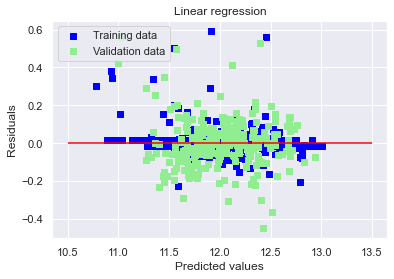

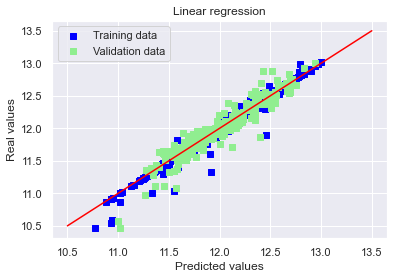

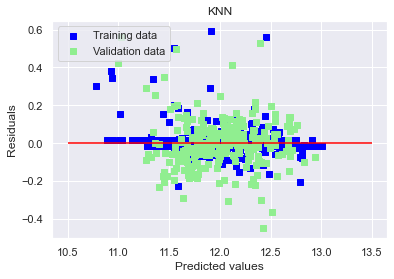

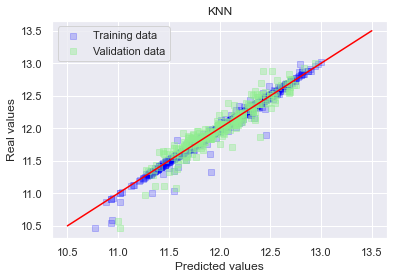

In [155]:
# Fit the training data
svm_hyp =  SVR(**params_svm)
svm_hyp.fit(X_train, y_train)

# Predict the validation data
y_train_svm = svm_hyp.predict(X_train)
y_test_svm = svm_hyp.predict(X_test)


# Compute the RMSE
train_error = mean_squared_error(y_train, y_train_svm,squared=False)
test_error = mean_squared_error(y_test, y_test_svm,squared=False)

print("SVM RMSE on Training set :", train_error)
print("SVM RMSE on Test set :", test_error)

plot_res(y_train_svm.reshape(1112,1),y_train,y_test_svm.reshape(278,1),y_test)

scores_dict['6. SVM'].append(test_error)

**7. Decision Tree**

In [57]:
from sklearn.tree import DecisionTreeRegressor

In [58]:
# Hyperparameter-tuning: Bayesian Optimization, bayes_opt
def dt_re_bo(splitter, max_depth, min_samples_split, min_samples_leaf, max_features):
    params_dt = {}
    
    splitterL = ['best', 'random']
    max_featuresL = ['auto', 'sqrt']
    
    params_dt['splitter'] = splitterL[round(splitter)]
    params_dt['max_depth'] = round(max_depth)
    params_dt['min_samples_split'] = round(min_samples_split)
    params_dt['min_samples_leaf'] = round(min_samples_leaf)
    params_dt['max_features'] = max_featuresL[floor(max_features)]
    
    scores = cross_val_score(DecisionTreeRegressor(random_state=42, **params_dt),
                             X_train, y_train, scoring=make_scorer(mean_squared_error, greater_is_better=False), cv=5).mean()
    score = ((scores*-1)**0.5)*-1
    return score

# Set hyperparameters spaces
params_dt ={
    'splitter':(0, 1),
    'max_depth':(4, 20),
    'min_samples_split':(1, 10),
    'min_samples_leaf':(1, 10),
    'max_features': (0, 1)
}

# Run Bayesian Optimization
dt_bo = BayesianOptimization(dt_re_bo, params_dt, random_state=42)
dt_bo.maximize(init_points=4, n_iter=25)



|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | splitter  |
-------------------------------------------------------------------------------------
|  1        | -0.1717   |  9.993    |  0.9507   |  7.588    |  6.388    |  0.156    |
|  2        | -0.1853   |  6.496    |  0.05808  |  8.796    |  6.41     |  0.7081   |
|  3        | -0.199    |  4.329    |  0.9699   |  8.492    |  2.911    |  0.1818   |
|  4        | -0.1732   |  6.934    |  0.3042   |  5.723    |  4.888    |  0.2912   |
|  5        | -0.1717   |  9.826    |  0.8524   |  7.809    |  6.495    |  0.3642   |
|  6        | -0.1876   |  9.156    |  0.0      |  2.929    |  7.302    |  1.0      |
|  7        | -0.1854   |  10.03    |  0.0      |  6.673    |  3.644    |  1.0      |
|  8        | -0.222    |  11.29    |  1.0      |  8.331    |  8.123    |  0.0      |
|  9        | -0.171    |  8.817    |  0.7201   |  7.056    |  5.821    |  0.302    |
|  10       | -0.1717   |  9.637    |  0.9489   |  8.4

In [59]:
# Best hyperparameters
params_dt = dt_bo.max['params']

splitterL = ['best', 'random']
max_featuresL = ['auto', 'sqrt']
    
params_dt['splitter'] = splitterL[round(params_dt['splitter'])]
params_dt['max_depth'] = round(params_dt['max_depth'])
params_dt['min_samples_split'] = round(params_dt['min_samples_split'])
params_dt['min_samples_leaf'] = round(params_dt['min_samples_leaf'])
params_dt['max_features'] = max_featuresL[floor(params_dt['max_features'])]
params_dt

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 7,
 'min_samples_split': 6,
 'splitter': 'best'}

DT RMSE on Training set : 0.11009320909803157
DT RMSE on Test set : 0.18024758967126964


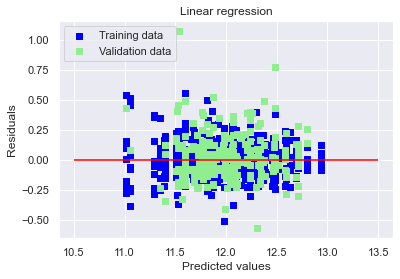

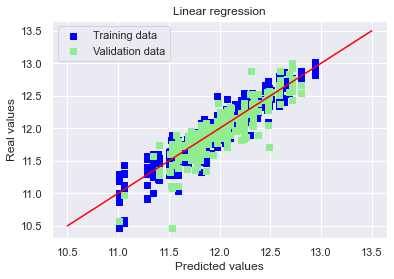

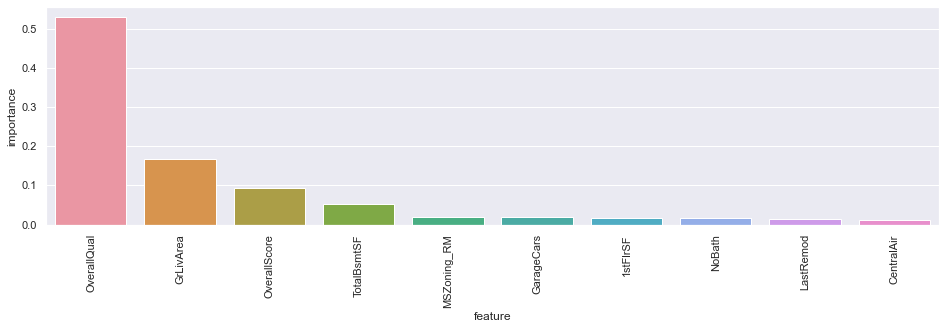

In [173]:
# Fit the training data
dt_hyp =  DecisionTreeRegressor(**params_dt, random_state=42)
dt_hyp.fit(X_train, y_train)

# Predict the validation data
y_train_dt = dt_hyp.predict(X_train)
y_test_dt = dt_hyp.predict(X_test)


# Compute the RMSE
train_error = mean_squared_error(y_train, y_train_dt,squared=False)
test_error = mean_squared_error(y_test, y_test_dt,squared=False)

print("DT RMSE on Training set :", train_error)
print("DT RMSE on Test set :", test_error)

plot_res(y_train_dt.reshape(1112,1),y_train,y_test_dt.reshape(278,1),y_test)

plot_feat3(algo=dt_hyp)

scores_dict['7. Decision Tree'].append(test_error)

**8. Random Forest**

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [63]:
# Hyperparameter-tuning: Bayesian Optimization, bayes_opt
def rf_re_bo(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params_rf = {}
        
    params_rf['n_estimators'] = round(n_estimators)
    params_rf['max_depth'] = round(max_depth)
    params_rf['min_samples_split'] = round(min_samples_split)
    params_rf['min_samples_leaf'] = round(min_samples_leaf)
    params_rf['max_features'] = float(max_features)
    
    scores = cross_val_score(RandomForestRegressor(random_state=123, **params_rf),
                             X_train, y_train, scoring=make_scorer(mean_squared_error,greater_is_better=False), cv=5).mean()
    score = ((scores*-1)**0.5)*-1
    return score

# Set hyperparameters spaces
params_rf ={
    'n_estimators':(70, 150),
    'max_depth':(5, 20),
    'min_samples_split':(2, 10),
    'min_samples_leaf': (2, 10),
    'max_features': (0.8,1)
}

# Run Bayesian Optimization
rf_bo = BayesianOptimization(rf_re_bo, params_rf, random_state=123)
rf_bo.maximize(init_points=4, n_iter=25)



|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -0.1318   |  15.45    |  0.8572   |  3.815    |  6.411    |  127.6    |
|  2        | -0.1375   |  11.35    |  0.9962   |  7.479    |  5.847    |  101.4    |
|  3        | -0.1354   |  10.15    |  0.9458   |  5.509    |  2.477    |  101.8    |
|  4        | -0.1308   |  16.07    |  0.8365   |  3.404    |  6.252    |  112.5    |
|  5        | -0.1316   |  16.0     |  0.8399   |  3.452    |  6.322    |  118.8    |
|  6        | -0.1321   |  9.244    |  0.9846   |  2.204    |  2.895    |  115.0    |
|  7        | -0.1379   |  19.41    |  0.8024   |  7.931    |  2.174    |  115.1    |
|  8        | -0.1317   |  12.93    |  0.89     |  2.0      |  8.003    |  114.9    |
|  9        | -0.1315   |  18.78    |  0.8      |  2.0      |  10.0     |  114.4    |
|  10       | -0.1319   |  10.03    |  0.9916   |  2.6

In [64]:
# Best hyperparameters
params_rf = rf_bo.max['params']

params_rf['n_estimators'] = round(params_rf['n_estimators'])
params_rf['max_depth'] = round(params_rf['max_depth'])
params_rf['min_samples_split'] = round(params_rf['min_samples_split'])
params_rf['min_samples_leaf'] = round(params_rf['min_samples_leaf'])
params_rf['max_features'] = float(params_rf['max_features'])
params_rf

{'max_depth': 20,
 'max_features': 0.8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

RF RMSE on Training set : 0.059830129411710745
RF RMSE on Test set : 0.13355595890306657


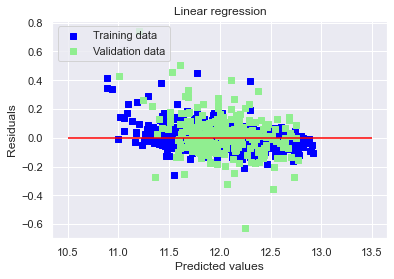

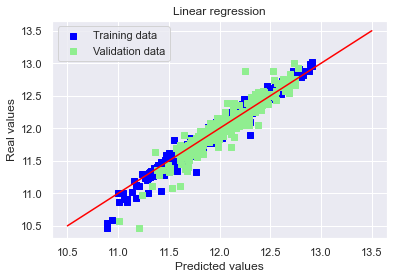

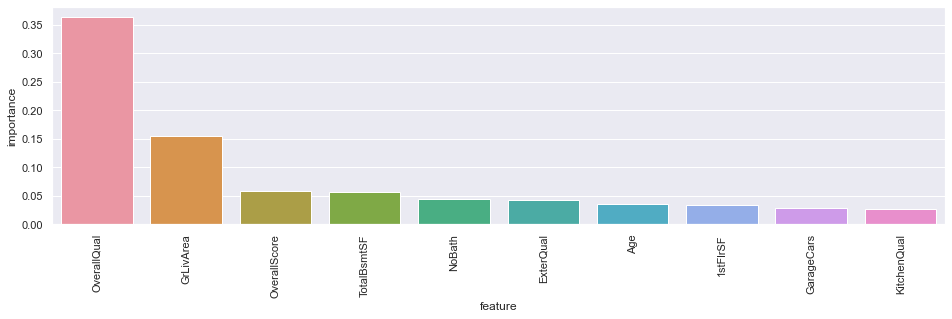

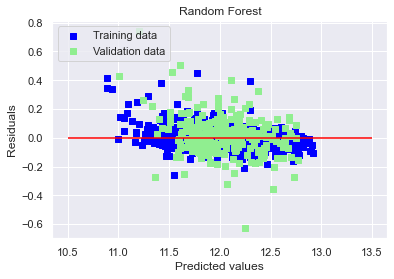

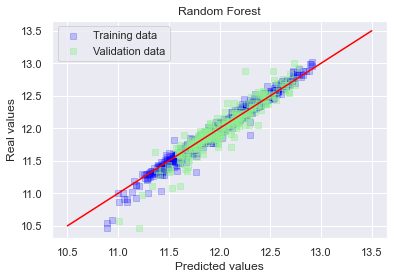

In [174]:
# Fit the training data
rf_hyp =  RandomForestRegressor(**params_rf, random_state=123)
rf_hyp.fit(X_train, y_train)

# Predict the validation data
y_train_rf = rf_hyp.predict(X_train)
y_test_rf = rf_hyp.predict(X_test)


# Compute the RMSE
train_error = mean_squared_error(y_train, y_train_rf,squared=False)
test_error = mean_squared_error(y_test, y_test_rf,squared=False)

print("RF RMSE on Training set :", train_error)
print("RF RMSE on Test set :", test_error)

plot_res(y_train_rf.reshape(1112,1),y_train,y_test_rf.reshape(278,1),y_test)

plot_feat3(algo=rf_hyp)

scores_dict['8. Random Forest'].append(test_error)

**9. Gradient Boosting Machine**

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

In [68]:
# Hyperparameter-tuning: Bayesian Optimization, bayes_opt
def gbm_re_bo(learning_rate, n_estimators, subsample, max_depth, max_features):
    params_gbm = {}
    params_gbm['learning_rate'] = learning_rate
    params_gbm['n_estimators'] = round(n_estimators)
    params_gbm['subsample'] = subsample
    params_gbm['max_depth'] = round(max_depth)
    params_gbm['max_features'] = float(max_features)
    
    scores = cross_val_score(GradientBoostingRegressor(random_state=123, **params_gbm),
                             X_train, y_train, scoring=make_scorer(mean_squared_error,greater_is_better=False), cv=5).mean()
    score = ((scores*-1)**0.5)*-1
    return score

# Set hyperparameters spaces
params_gbm ={
    'learning_rate':(0.01, 1),
    'n_estimators':(80, 150),
    'subsample': (0.8, 1),
    'max_depth':(5, 20),
    'max_features':(0.8, 1)
}

# Run Bayesian Optimization
gbm_bo = BayesianOptimization(gbm_re_bo, params_gbm, random_state=123)
gbm_bo.maximize(init_points=4, n_iter=25)

|   iter    |  target   | learni... | max_depth | max_fe... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.1642   |  0.6995   |  9.292    |  0.8454   |  118.6    |  0.9439   |
|  2        | -0.16     |  0.4289   |  19.71    |  0.937    |  113.7    |  0.8784   |
|  3        | -0.1483   |  0.3497   |  15.94    |  0.8877   |  84.18    |  0.8796   |
|  4        | -0.1709   |  0.7406   |  7.737    |  0.8351   |  117.2    |  0.9064   |
|  5        | -0.158    |  0.4943   |  16.91    |  0.8431   |  86.68    |  0.9299   |
|  6        | -0.1684   |  0.6461   |  16.24    |  0.9972   |  82.09    |  0.9498   |
|  7        | -0.1917   |  0.8542   |  8.677    |  0.9079   |  106.4    |  0.8175   |
|  8        | -0.2032   |  0.01     |  14.73    |  0.8      |  85.33    |  0.8      |
|  9        | -0.1472   |  0.4085   |  19.86    |  0.8568   |  113.5    |  0.8522   |
|  10       | -0.1232   |  0.1469   |  5.196    |  0.8

In [69]:
# Best hyperparameters
params_gbm = gbm_bo.max['params']
params_gbm['max_depth'] = round(params_gbm['max_depth'])
params_gbm['n_estimators'] = round(params_gbm['n_estimators'])
params_gbm['max_features'] = float(params_gbm['max_features'])
params_gbm

{'learning_rate': 0.0464286651302317,
 'max_depth': 5,
 'max_features': 0.8684547555162566,
 'n_estimators': 121,
 'subsample': 0.8471920324783148}

GBM RMSE on Training set : 0.05508480031218192
GBM RMSE on Test set : 0.1204243523599286


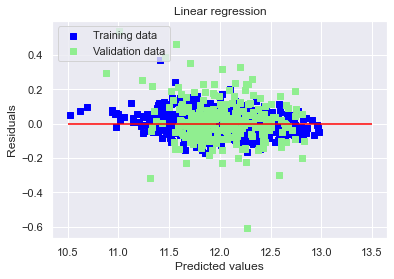

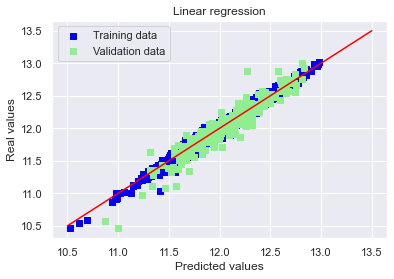

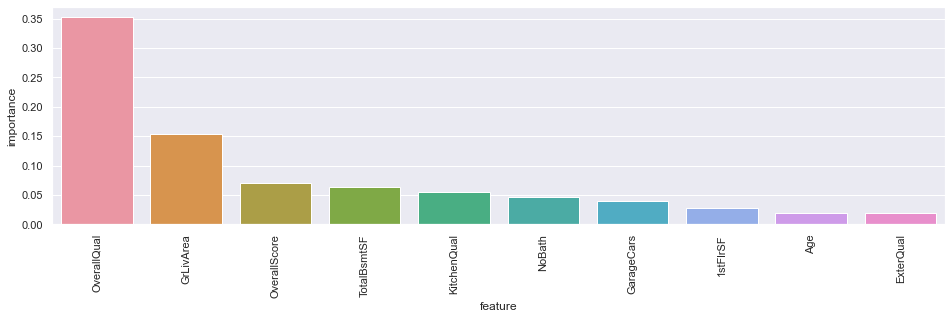

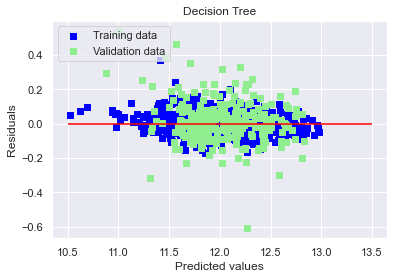

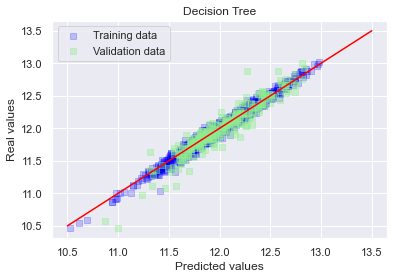

In [176]:
# Fit the training data
gbm_hyp =  GradientBoostingRegressor(**params_gbm, random_state=123)
gbm_hyp.fit(X_train, y_train)

# Predict the validation data
y_train_gbm = gbm_hyp.predict(X_train)
y_test_gbm = gbm_hyp.predict(X_test)


# Compute the RMSE
train_error = mean_squared_error(y_train, y_train_gbm,squared=False)
test_error = mean_squared_error(y_test, y_test_gbm,squared=False)

print("GBM RMSE on Training set :", train_error)
print("GBM RMSE on Test set :", test_error)

plot_res(y_train_gbm.reshape(1112,1),y_train,y_test_gbm.reshape(278,1),y_test)

plot_feat3(algo=gbm_hyp)

scores_dict['9. GBM'].append(test_error)


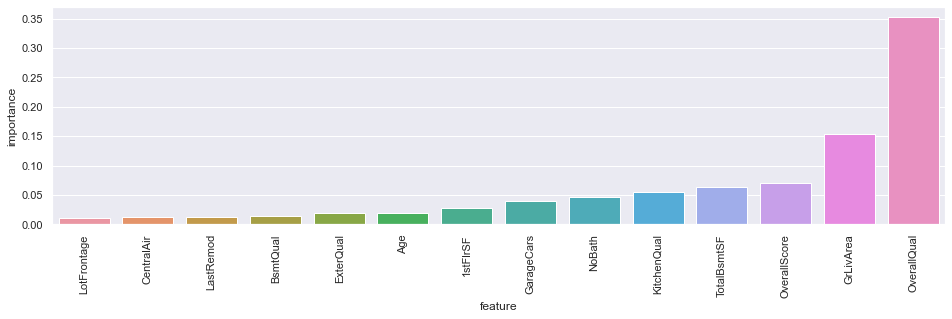

In [71]:
# Feature importances
Feature_gbm = pd.DataFrame({'feature':X_train.columns, 'importance':list(gbm_hyp.feature_importances_)}).sort_values('importance')
Feature_gbm = Feature_gbm[Feature_gbm['importance']>0.01]
plt.figure(figsize=(16,4))
sns.barplot(data=Feature_gbm, x='feature', y='importance')
plt.xticks(rotation=90)
plt.show()

**10. LightGBM**

In [72]:
from lightgbm import LGBMRegressor

In [73]:
# Hyperparameter-tuning: Bayesian Optimization, bayes_opt
def lgbm_re_bo(num_leaves, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree):
    params_lgbm = {'objective': 'regression'}
    params_lgbm['num_leaves'] = round((2**round(max_depth))*num_leaves)
    params_lgbm['max_depth'] = round(max_depth)
    params_lgbm['learning_rate'] = learning_rate
    params_lgbm['min_child_weight'] = min_child_weight
    params_lgbm['subsample'] = subsample
    params_lgbm['colsample_bytree'] = colsample_bytree
    
    scores = cross_val_score(LGBMRegressor(random_state=123, **params_lgbm),
                            X_train, y_train, scoring=make_scorer(mean_squared_error,greater_is_better=False), cv=5).mean()
    score = ((scores*-1)**0.5)*-1
    return score

# Set parameters distribution
params_lgbm ={
    'num_leaves':(0.5,0.9),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.5),
    'min_child_weight':(1e-5, 1e-1),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1)
}

# Run Bayesian Optimization
lgbm_bo = BayesianOptimization(lgbm_re_bo, params_lgbm, random_state=123)
lgbm_bo.maximize(init_points=2, n_iter=25)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.1251   |  0.8482   |  0.1502   |  5.722    |  0.05514  |  0.7878   |  0.7116   |
|  2        | -0.134    |  0.9904   |  0.3456   |  8.771    |  0.03922  |  0.6373   |  0.8645   |
|  3        | -0.1316   |  0.8608   |  0.4404   |  3.041    |  0.0931   |  0.8339   |  0.9537   |
|  4        | -0.1257   |  0.868    |  0.2141   |  3.082    |  0.09736  |  0.7903   |  0.823    |
|  5        | -0.1377   |  0.8319   |  0.351    |  8.443    |  0.09707  |  0.7321   |  0.5414   |
|  6        | -0.1403   |  0.6457   |  0.4591   |  5.499    |  0.07327  |  0.8473   |  0.7964   |
|  7        | -0.1245   |  0.8491   |  0.1193   |  5.769    |  0.03869  |  0.8484   |  0.7271   |
|  8        | -0.1969   |  1.0      |  0.01     |  5.892    |  0.04764  |  0.7054   |  0.6308   |
|  9        | -0.125

In [74]:
# Best hyperparameters
params_lgbm = lgbm_bo.max['params']
params_lgbm['max_depth'] = round(params_lgbm['max_depth'])
params_lgbm['num_leaves'] = round((2**round(params_lgbm['max_depth']))*params_lgbm['num_leaves'])
params_lgbm

{'colsample_bytree': 0.6781636992560199,
 'learning_rate': 0.06963718479228403,
 'max_depth': 6,
 'min_child_weight': 0.07146642433772117,
 'num_leaves': 50,
 'subsample': 0.9116222522411446}

lgbm RMSE on Training set : 0.07388347494011235
lgbm RMSE on Test set : 0.12120015967702874


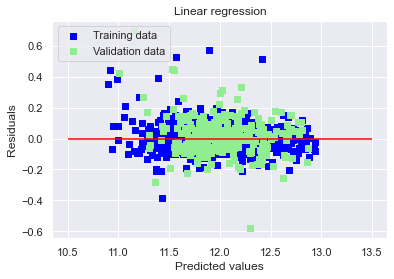

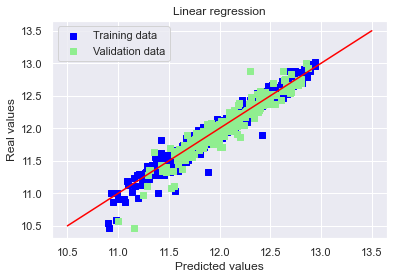

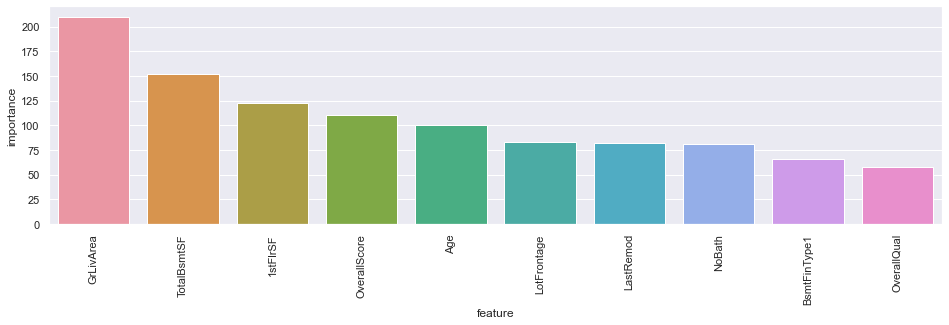

In [177]:
# Fit the training data
lgbm_hyp =  LGBMRegressor(**params_lgbm, random_state=42)
lgbm_hyp.fit(X_train, y_train)

# Predict the validation data
y_train_lgbm = lgbm_hyp.predict(X_train)
y_test_lgbm = lgbm_hyp.predict(X_test)


# Compute the RMSE
train_error = mean_squared_error(y_train, y_train_lgbm,squared=False)
test_error = mean_squared_error(y_test, y_test_lgbm,squared=False)

print("lgbm RMSE on Training set :", train_error)
print("lgbm RMSE on Test set :", test_error)

plot_res(y_train_lgbm.reshape(1112,1),y_train,y_test_lgbm.reshape(278,1),y_test)

plot_feat3(algo=lgbm_hyp)


scores_dict['10. LGBM'].append(test_error)

**11. XGBoost**

In [77]:
from xgboost import XGBRegressor

In [78]:
# Hyperparameter tuning: Bayesian Optimization
def xgb_re_bo(learning_rate, gamma, max_depth, min_child_weight, subsample, colsample_bytree):
    params_xgb = {
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    'nthread':-1
     }
    
    params_xgb['learning_rate'] = learning_rate
    params_xgb['gamma'] = gamma
    params_xgb['max_depth'] = round(max_depth)
    params_xgb['min_child_weight'] = round(min_child_weight)
    params_xgb['subsample'] = subsample
    params_xgb['colsample_bytree'] = colsample_bytree
    
    scores = cross_val_score(XGBRegressor(random_state=123, **params_xgb),
                            X_train, y_train, scoring=make_scorer(mean_squared_error,greater_is_better=False), cv=5).mean()
    score = ((scores*-1)**0.5)*-1
    return score

# Set parameters distribution
params_xgb ={
    'learning_rate': (0.01, 0.5),
    'gamma':(0, 10),
    'max_depth': (3, 15),
    'min_child_weight':(3, 10),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.1, 1)
}

# Run Bayesian Optimization
xgb_bo = BayesianOptimization(xgb_re_bo, params_xgb, random_state=123)
xgb_bo.maximize(init_points=4, n_iter=25)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.1809   |  0.7268   |  2.861    |  0.1212   |  9.616    |  8.036    |  0.7116   |
|  2        | -0.2145   |  0.9827   |  6.848    |  0.2457   |  7.705    |  5.402    |  0.8645   |
|  3        | -0.1441   |  0.4947   |  0.5968   |  0.205    |  11.86    |  4.277    |  0.5877   |
|  4        | -0.2024   |  0.5784   |  5.318    |  0.3209   |  13.19    |  8.071    |  0.8055   |
|  5        | -3.569    |  0.7495   |  8.784    |  0.01168  |  14.17    |  8.843    |  0.9537   |
|  6        | -3.022    |  0.7624   |  4.166    |  0.01334  |  14.68    |  8.081    |  0.823    |
|  7        | -0.2286   |  0.6974   |  6.959    |  0.2323   |  14.65    |  7.061    |  0.5414   |
|  8        | -0.2341   |  0.3622   |  9.165    |  0.1121   |  11.79    |  9.077    |  0.7964   |
|  9        | -0.202

In [79]:
# Best hyperparameters
params_xgb = xgb_bo.max['params']
params_xgb['objective'] = 'reg:squarederror'
params_xgb['eval_metric'] = 'rmse'
params_xgb['n_jobs'] = -1
params_xgb['max_depth'] = round(params_xgb['max_depth'])
params_xgb['min_child_weight'] = round(params_xgb['min_child_weight'])
xgb_bo.max['params']

{'colsample_bytree': 0.494715020211662,
 'gamma': 0.5967789660956835,
 'learning_rate': 0.2050416851119114,
 'max_depth': 11.855944868784428,
 'min_child_weight': 4.2774421131745,
 'subsample': 0.5877258780737462}

xgb RMSE on Training set : 0.12781262705851007
xgb RMSE on Test set : 0.14071842146728542


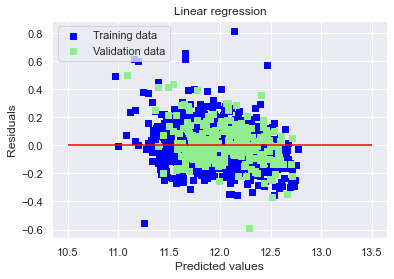

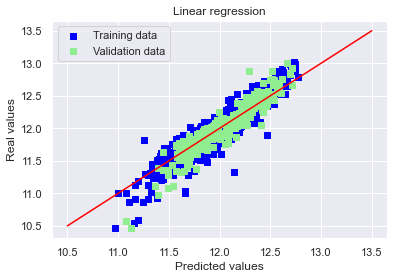

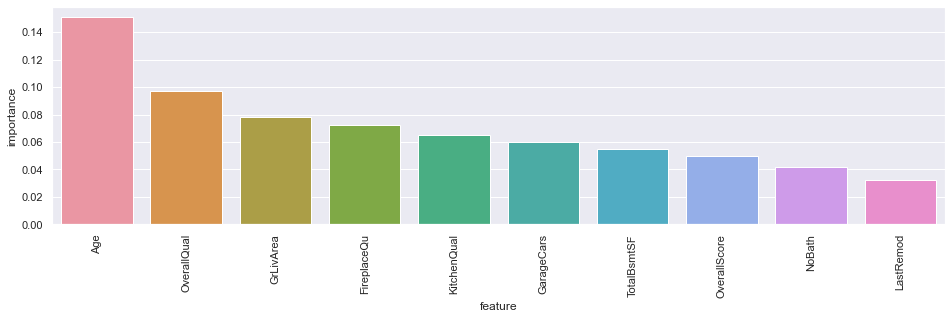

In [178]:
# Fit the training data
xgb_hyp =  XGBRegressor(**params_xgb, random_state=123)
xgb_hyp.fit(X_train, y_train)

# Predict the validation data
y_train_xgb = xgb_hyp.predict(X_train)
y_test_xgb = xgb_hyp.predict(X_test)


# Compute the RMSE
train_error = mean_squared_error(y_train, y_train_xgb,squared=False)
test_error = mean_squared_error(y_test, y_test_xgb,squared=False)

print("xgb RMSE on Training set :", train_error)
print("xgb RMSE on Test set :", test_error)

plot_res(y_train_xgb.reshape(1112,1),y_train,y_test_xgb.reshape(278,1),y_test)
plot_feat3(algo=xgb_hyp)

scores_dict['11. XGBoost'].append(test_error)

In [83]:
pd.DataFrame.from_dict(scores_dict, orient='index', columns=['test accuracy']).sort_values(by='test accuracy', ascending=True)

test accuracy
3. Lasso Regression        0.112385
4. Elastic Net             0.112387
2. Ridge Regression        0.116215
1. Linear Regression       0.120187
9. GBM                     0.120424
10. LGBM                   0.121200
6. SVM                     0.125684
8. Random Forest           0.133556
11. XGBoost                0.140718
7. Decision Tree           0.180248
5. KNN                     0.187657

### 5. Step: Discussion of results